In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = "./data"
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

device(type='mps')

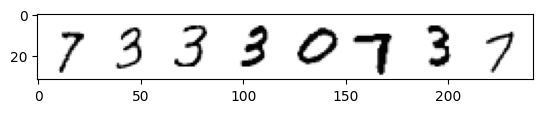

In [ ]:
dataset = torchvision.datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, _ = next(iter(train_dataloader))
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [5]:
def corrupt(x, amount):
    """
    corrupt the input `x` by mixing it with noise
    x: (B, 1, 28, 28)
    amount: (B) different amount of noise for different samples
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


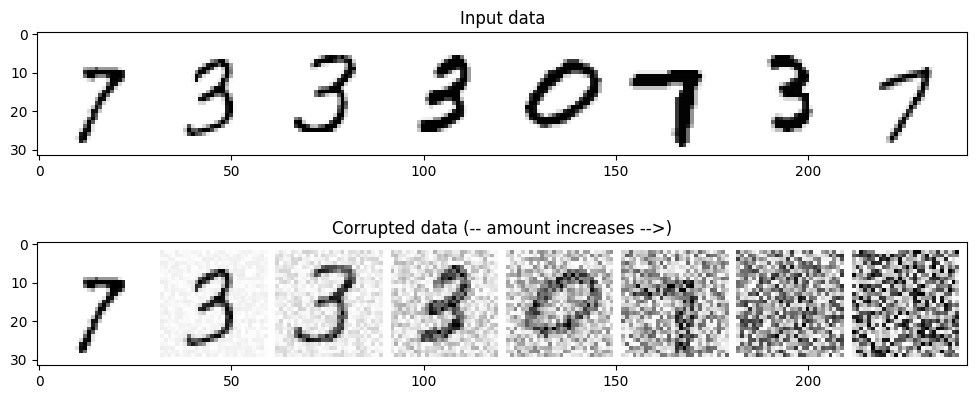

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
print(amount)
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels, 32, kernel_size=5, padding=2
                ),  # (B, 1, 28, 28) => (B, 32, 28, 28)
                nn.Conv2d(
                    32, 64, kernel_size=5, padding=2
                ),  # (B, 32, 28, 28) => (B, 64, 28, 28)
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )

        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        self.act = nn.SiLU()

        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        hiddens = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
                hiddens.append(x)
                x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += hiddens.pop()

            x = self.act(layer(x))

        return x

In [29]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 10

net = (
    UNet()
)  # This UNet is trained to predict the original image from the corrupted image
net.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

for epoch in range(epochs):
    print(f"[-info] Starting epoch {epoch}")
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)

        loss = criterion(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

[-info] Starting epoch 0


100%|██████████| 469/469 [00:13<00:00, 35.71it/s]


Finished epoch 0. Average loss for this epoch: 0.025730
[-info] Starting epoch 1


100%|██████████| 469/469 [00:12<00:00, 36.95it/s]


Finished epoch 1. Average loss for this epoch: 0.019924
[-info] Starting epoch 2


100%|██████████| 469/469 [00:12<00:00, 37.24it/s]


Finished epoch 2. Average loss for this epoch: 0.018207
[-info] Starting epoch 3


100%|██████████| 469/469 [00:13<00:00, 35.90it/s]


Finished epoch 3. Average loss for this epoch: 0.017375
[-info] Starting epoch 4


100%|██████████| 469/469 [00:12<00:00, 36.73it/s]


Finished epoch 4. Average loss for this epoch: 0.016986
[-info] Starting epoch 5


100%|██████████| 469/469 [00:13<00:00, 35.99it/s]


Finished epoch 5. Average loss for this epoch: 0.016408
[-info] Starting epoch 6


100%|██████████| 469/469 [00:14<00:00, 32.48it/s]


Finished epoch 6. Average loss for this epoch: 0.016340
[-info] Starting epoch 7


100%|██████████| 469/469 [00:19<00:00, 24.33it/s]


Finished epoch 7. Average loss for this epoch: 0.016052
[-info] Starting epoch 8


100%|██████████| 469/469 [00:19<00:00, 24.65it/s]


Finished epoch 8. Average loss for this epoch: 0.015949
[-info] Starting epoch 9


100%|██████████| 469/469 [00:19<00:00, 24.59it/s]

Finished epoch 9. Average loss for this epoch: 0.015580


(0.0, 0.1)

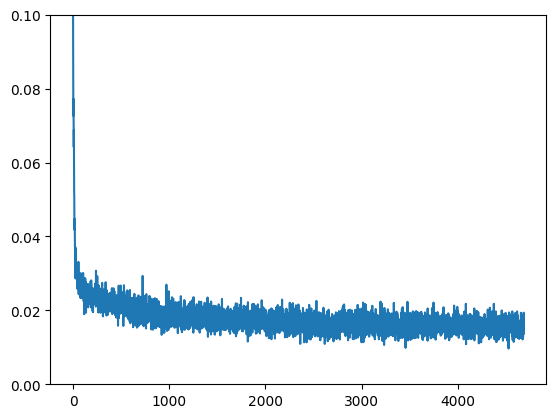

In [30]:
plt.plot(losses)
plt.ylim(0, 0.1)

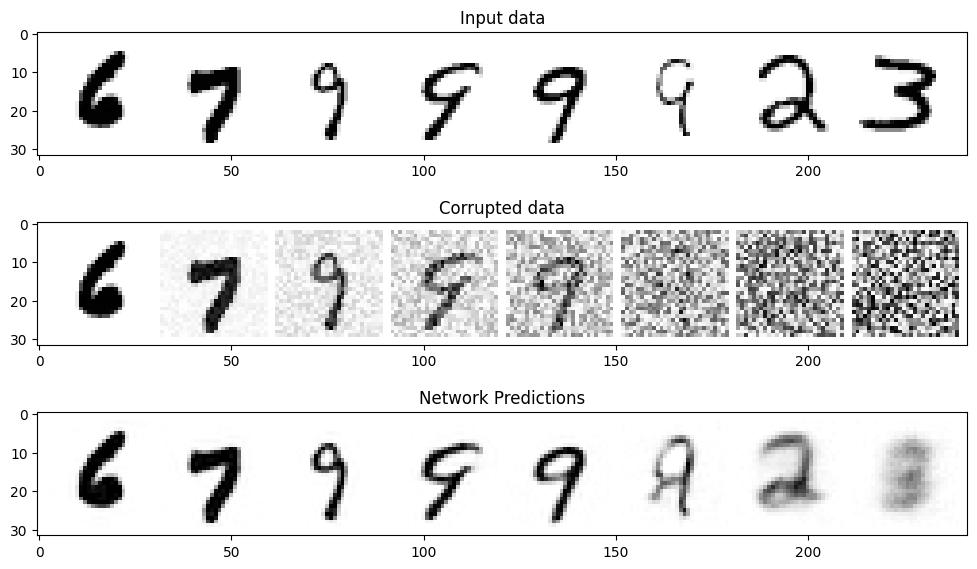

In [31]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

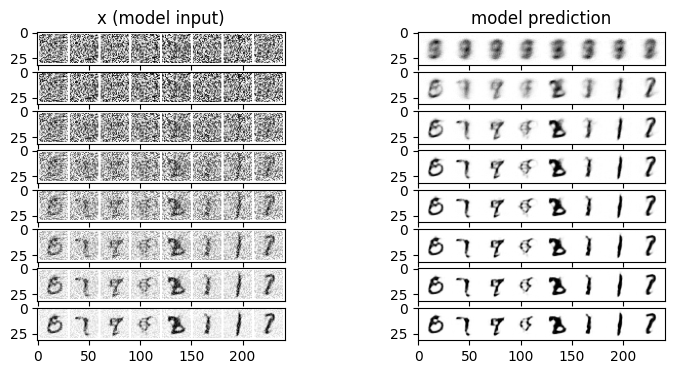

In [32]:
n_steps = 8
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)

    step_history.append(x.detach().cpu())
    pred_output_history.append(pred.detach().cpu())
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys"
    )

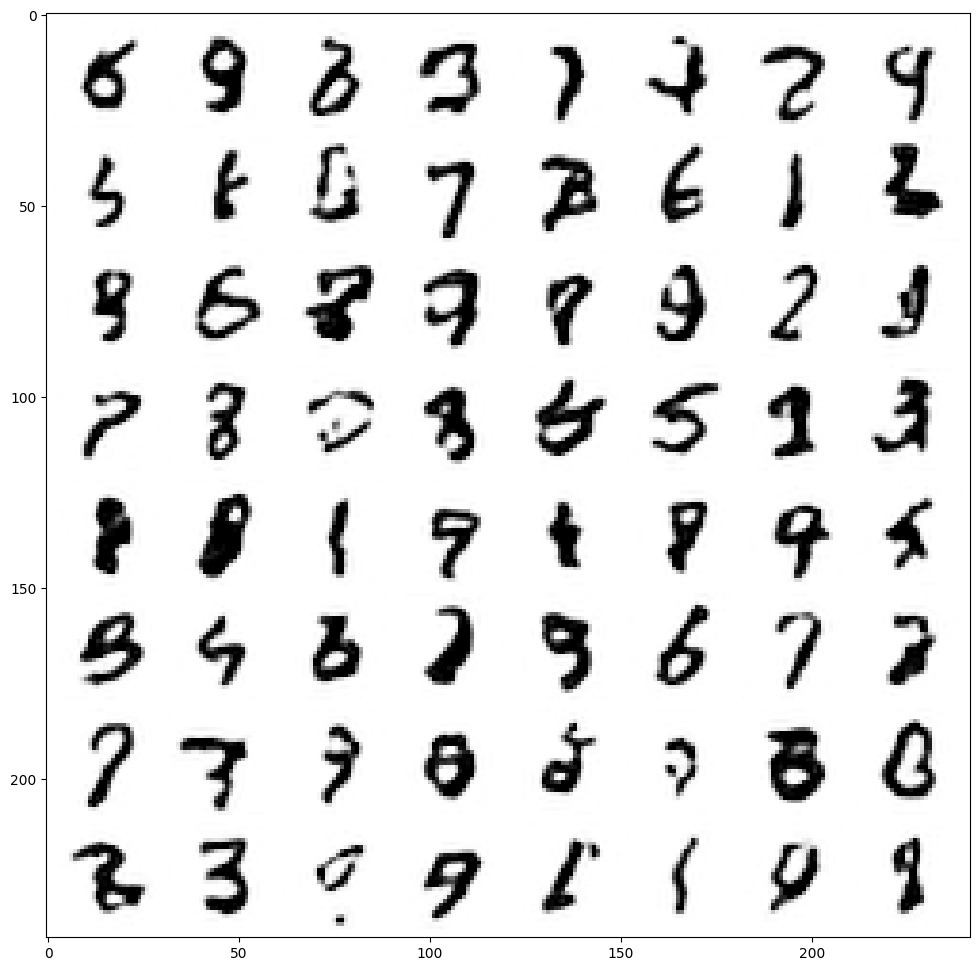

In [33]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys"
)